In [357]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import numpy as np, pandas as pd

def chi2(y,yfit):
    res = 0
    for i in range(len(yfit)):
        res = res + (y[i]-yfit[i])**2/(0.9724)**2 #The denominator should be the unbias Sipm voltage in mV
    return (res / len(yfit))

def waveform(x, C, start, m, end, A, d):
    condlist = [x < start, (x >= start) & (x < end), x >= end]
    funclist = [lambda x: C, lambda x: m*x+(C - m*start), lambda x: (A * np.exp(d * x) + (m*end + (C - m*start) - A * np.exp(d*end)))]
    return np.piecewise(x, condlist, funclist)

def gaus(x, const, mu, sigma):
    return const* np.exp(-0.5*((x - mu)/sigma)**2)

In [350]:
inputfile = "../TwofoldTrigger/5.txt"
outputfile = '../TwofoldTrigger/ORtrig300.txt'
filenumber = 1
channelnum = [1,2,3,4] #DRS4 board channel, ranges 1 to 4 -- should be expanded to do multiple channels at once.  
eventview = False

p0=[(0,100,1,110,300,-0.01),
    (0,100,1,110,300,-0.01),
    (0,100,1,110,40,-0.01),
    (0,100,1,110,40,-0.01)] #p0:C,start,m,end,A,d -- adjust start and end to match approx time of pulse falling edge
chi2cut = 2
Vcut = 10 #cut just above noise level, in (mV) 

channelnames=[]
for ch in channelnum:
    channelnames.append(f'ch{ch}')

In [351]:
din = {a+"_"+b:[] for a in channelnames for b in "P2P time chisq".split()}
#p2ps = np.array([])
#chisqs = np.array([])
with open(outputfile, 'w') as w:
    #w.write("")
    for i in range(0, filenumber):                             #iterate through files
        w.write(f"File {i}, Channel(s) {channelnum}")
        with open(inputfile) as f:                            #modify to iterate through chosen filenames
            current_file = (f.read().split('-- Event'))
        
        for j in range(1, len(current_file)):                  #iterate through events  
            
            time = np.array([])
            voltage = [np.array([])]*4
            lines = current_file[j].split('\n')
            #w.write(f"{j},")
            
            if eventview: #show the waveform fit line
                print(f"Event Number {j}")
                fig,ax = plt.subplots(1,4,figsize=(10,3))
                ax[0].set_title("Ch. 1")
                ax[1].set_title("Ch. 2")
                ax[2].set_title("Ch. 3")
                ax[3].set_title("Ch. 4")
            
            for line in lines[6:1028]:                         #iterate through data points
                values = line.split()
                time = np.append(time, float(values[2]))
                for channel in channelnum:
                    #if float(values[channelnum+2]) < Vcut: continue            #cut the false peaks from the DRS4
                    voltage[channel-1] = np.append(voltage[channel-1], float(values[channel+2]))
            w.write('\n')
            for channel in channelnum:
                #print(f'Channel Number {channel}')
                popt, pcov = curve_fit(waveform, time, voltage[channel-1],p0=p0[channel-1],
                                       maxfev = 100000)#,bounds=([-10,60,0,60,0,-1],[10,140,100,140,3000,0])
                
                for i in range(len(time)): 
                    if time[i] < popt[1]: startindex = i
                    else: break
                print(f"Event: {j}, Channel: {channel}",end="\r")
                chisq = chi2(voltage[channel-1][0:startindex],waveform(time[0:startindex], *popt))

                din[f'ch{channel}_P2P'].append(popt[2]*(popt[3] - popt[1]))
                din[f'ch{channel}_time'].append(popt[1])
                din[f'ch{channel}_chisq'].append(chisq)
                
                w.write(f"{popt[2]*(popt[3] - popt[1]):.1f}\t")
                w.write(f"{popt[1]:.1f}\t")
                w.write(f"{chisq:.2f}\t")
                
                if eventview: #show the waveform fit line
                    print(f"Channel {channel} params: {popt}")
                    xs = []
                    ys = []
                    for i in range(500):
                        xs.append(i)
                        if i < popt[1]: ys.append(popt[0])
                        elif i < popt[3]: ys.append(i*popt[2]+popt[0]-popt[2]*popt[1])
                        else: ys.append(popt[4] * np.exp(popt[5] * i) + (popt[2]*popt[3] + (popt[0] - popt[2]*popt[1]) - popt[4] * np.exp(popt[5]*popt[3])))
                    ax[channel-1].plot(time,voltage[channel-1])
                    ax[channel-1].plot(xs,ys)
            plt.show()
                

print(f'Done!\nTotal events analyzed: {len(din["ch2_chisq"])}')
dfin = pd.DataFrame(din)

Done!: 3037, Channel: 4, Start Index: 167
Total events analyzed: 3037


In [358]:
with open(outputfile) as f:  
    nevents = (f.read().split('\n'))
    nchannelnums = nevents[0].split('[')[1].split(']')[0].split(', ')
    nchannelnames=[]
    for ch in nchannelnums:
        nchannelnames.append(f'ch{ch}')
    dout = {a+"_"+b:[] for a in nchannelnames for b in "P2P time chisq".split()}
    
    for event in nevents[1:]:
        #print(f'Event: {event}')
        nvalues = event.split()
        if len(values) == 0: continue
        for i in range(len(nchannelnames)):
            #print(i)
            dout[f'{nchannelnames[i]}_P2P'].append(float(nvalues[3*i]))
            dout[f'{nchannelnames[i]}_time'].append(float(nvalues[3*i+1]))
            dout[f'{nchannelnames[i]}_chisq'].append(float(nvalues[3*i+2]))
dfout = pd.DataFrame(dout)


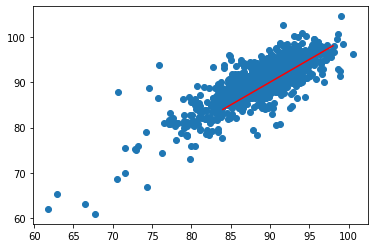

In [359]:
plt.scatter(dfout.query("ch3_P2P>10 & ch4_P2P>10").ch3_time,dfout.query("ch3_P2P>10 & ch4_P2P>10").ch4_time)
plt.plot(np.linspace(84,98,20),np.linspace(84,98,20),color="red")
plt.show()

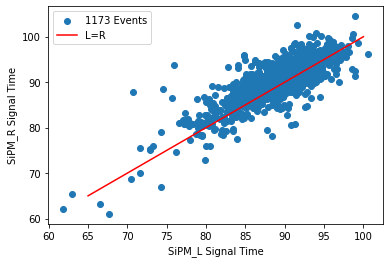

In [369]:
plt.scatter(dfin.query("ch3_P2P>10 & ch4_P2P>10").ch3_time,dfin.query("ch3_P2P>10 & ch4_P2P>10").ch4_time,label=f"{len(dfin.query('ch3_P2P>10 & ch4_P2P>10').ch4_time)} Events")
plt.plot(np.linspace(65,100,2),np.linspace(65,100,2),color="red",label="L=R")
plt.xlabel("SiPM_L Signal Time")
plt.ylabel("SiPM_R Signal Time")
plt.legend()
plt.show()

Actual Average: 1.37, Actual st.dev.: 2.85
Fit Average:    1.46, Fit st.dev.:    2.28


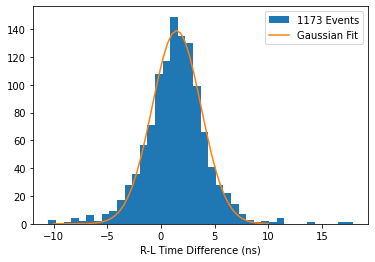

In [371]:
count,binedges,bars=plt.hist(dfin.query("ch3_P2P>10 & ch4_P2P>10").ch4_time-dfin.query("ch3_P2P>10 & ch4_P2P>10").ch3_time,40, label=f"{len(dfin.query('ch3_P2P>10 & ch4_P2P>10').ch4_time)} Events")

bincenters = binedges[1:]/2+binedges[:-1]/2
avg=0
stdev=0
for i in range(len(bincenters)):
    avg +=bincenters[i]*count[i]
avg = avg/sum(count)
for i in range(len(bincenters)):
    stdev +=(bincenters[i]-avg)**2*count[i]
stdev = np.sqrt(stdev/sum(count))


coeff, covar = curve_fit(gaus, bincenters, count)
print(f"Actual Average: {avg:.2f}, Actual st.dev.: {stdev:.2f}")
print(f"Fit Average:    {coeff[1]:.2f}, Fit st.dev.:    {coeff[2]:.2f}")

plt.plot(np.linspace(-10,10,50),gaus(np.linspace(-10,10,50),coeff[0],coeff[1],coeff[2]),label="Gaussian Fit")
plt.xlabel("R-L Time Difference (ns)")
plt.legend()
plt.show()

In [331]:
bincenters = binedges[1:]/2+binedges[:-1]/2


128.5674129524628
105.54288053244646
84.78829210627865
66.30364767395936
50.088947235488604
36.144190790866375
24.469378340092668
15.064509883167494
7.929585420090843
3.064604950862719
0.4695684754831221
0.1444759939520523
2.08932750626951
6.304123012435494
12.788862512450006
21.54354600631305
32.56817349402462
45.86274497558471
61.42726045099333
79.26171992025048
1.389463270128847 2.583943254278519


In [322]:
len(count)

20